<a href="https://colab.research.google.com/github/ElisonSherton/fastai-basic-notebooks/blob/master/Fastai_Toxic_Comment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxic Comment Classification using fastai2

Natural Language Processing is a sub field of Artificial Intelligence which deals with using tools in order to process and understand textual data.

Unlike most image and tabular data, text data comes exclusively in sequences. So, the architecture and technique behind solving these problems is quite different from solving an image/tabular data use-case.

In [this Kaggle Competition](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge), contestants have to build a model which can parse the comments which are basically sentences and tell whether the comment falls in one of the following categories:

- toxic
- severe toxic
- obscene
- threat
- insult
- identity hate

These are all comments which are taken from Wikipedia and they're manually labelled by humans to belong to one of these six kinds of comments. 

Without further ado, let's get started.

In [ ]:
# Install fastai
!pip install -Uqq fastbook
!pip install fastai --upgrade

In [2]:
# Import all the libraries needed for this problem
import os
from fastai import *
from fastai.data.all import *
from fastai.text.all import *
from IPython.display import display_html
pd.set_option('display.max_colwidth', None)
plt.style.use("fivethirtyeight")

In [ ]:
# Set your username and key from the kaggle API from your account
os.environ["KAGGLE_USERNAME"] = "###"
os.environ["KAGGLE_KEY"] = "###"
os.chdir("/content/drive/My Drive/Colab Notebooks")
os.mkdir("Toxic Comments Data")
os.chdir("./Toxic Comments Data")

# Download the data from kaggle to the directory you just created
!pip install kaggle
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

In [ ]:
# Unzip all the csv files and remove the zip files
!unzip train.csv.zip && rm train.csv.zip
!unzip test.csv.zip && rm test.csv.zip
!unzip test_labels.csv.zip && rm test_labels.csv.zip
!unzip sample_submission.csv.zip && rm sample_submission.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [4]:
# Read in the train and test sets.
os.chdir("/content/drive/My Drive/Colab Notebooks/Toxic Comments Data")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
# Look at a few entries from the dataset
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


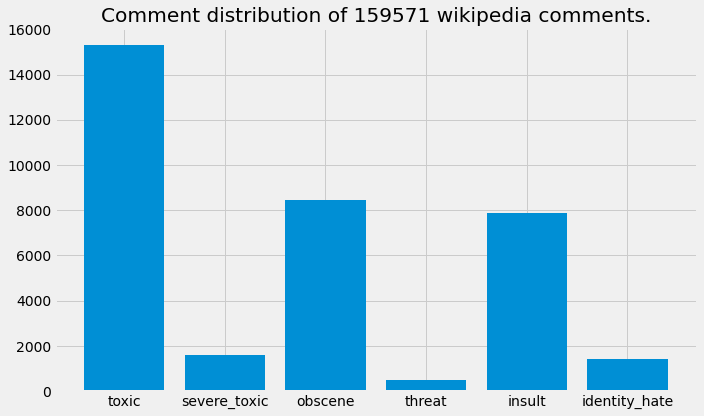

In [ ]:
# Look at the distribution of comments
f = lambda x: train_df[x].sum()

comment_types = train_df.columns[2:]
comment_counts = [f(x) for x in comment_types]

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
plt.bar(comment_types, comment_counts)
ax.set_title(f"Comment distribution of {len(train_df)} wikipedia comments.")
plt.tight_layout();

# Creating Language Model

In [ ]:
# For building a language model, we can basically use both train and test data so that the embeddings are
# created and refined for many observed words.
lm_df = train_df[["id", "comment_text"]].append(test_df).reset_index(drop = True)

In [ ]:
lm_df

,id,comment_text
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)"
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?"
...,...,...
312730,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing but too-long-crap"
312731,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n Does it get there faster by throwing to cut off man or direct from out fielder? \n Were the out fielders in the Mickey mantle era have better arms? \n Rich
312732,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I see your changes and agree this is """"more correct."""" I had gotten confused, but then found this: \n :... while acknowledging Japan's territorial rights to Okinotorishima itself ... \n However, is there a category for \n :... did not acknowledge Japan's claim to an exclusive economic zone (EEZ) stemming from Okinotorishima. \n That is, is there a category for """"disputed EEZ""""s? """
312733,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the EU - Germany - has a Law of Return quite similar to Israel's"""" == \n\n This isn't actually true, is it? Germany allows people whose ancestors were citizens of Germany to return, but AFAIK it does not allow the descendants of Anglo-Saxons to """"return"""" to Angeln and Saxony. Israel, by contrast, allows all Jews to """"return"""" to Israel, even if they can't trace a particular ancestral line to anyone who lived in the modern state or even mandate Palestine. — """


In [ ]:
# Tokenize the dataframe created above to have all the descriptions tokenized properly and build a dataloader
# For creating a language model
dls_lm = TextDataLoaders.from_df(lm_df,
                                 text_col='comment_text',
                                 valid_pct = .2,
                                 is_lm = True,
                                 seq_len = 72,
                                 bs = 64)

In [ ]:
# Have a look at two random entries from the language model created above
dls_lm.show_batch(max_n = 2)

,text,text_
0,"xxbos "" \n\n▁ = = sockpuppetry case== \n▁ { | align=""""left "" "" \n▁ || \n▁ | } \n▁ xxmaj you have been accused of sockpuppetry . xxmaj please refer to for evidence . xxmaj please make sure you make yourself familiar with notes for the suspect before editing the evidence page . "" xxbos : technically both , as xxmaj xxunk contains only xxmaj xxunk . xxbos 3rd xxmaj term \n\n",""" \n\n▁ = = sockpuppetry case== \n▁ { | align=""""left "" "" \n▁ || \n▁ | } \n▁ xxmaj you have been accused of sockpuppetry . xxmaj please refer to for evidence . xxmaj please make sure you make yourself familiar with notes for the suspect before editing the evidence page . "" xxbos : technically both , as xxmaj xxunk contains only xxmaj xxunk . xxbos 3rd xxmaj term \n\n xxmaj"
1,"and a detailed one below ? xxbos "" \n\n▁ = = xxmaj we need pie = = \n\n▁ { | style=""""background - color : # fdffe7 ; border : 1px solid # fceb92 ; "" "" \n▁ |style=""""vertical - align : middle ; padding : 5px ; "" "" | \n▁ |style=""""vertical - align : middle ; padding : 3px ; "" "" | xxmaj life throws us all curve balls ,","a detailed one below ? xxbos "" \n\n▁ = = xxmaj we need pie = = \n\n▁ { | style=""""background - color : # fdffe7 ; border : 1px solid # fceb92 ; "" "" \n▁ |style=""""vertical - align : middle ; padding : 5px ; "" "" | \n▁ |style=""""vertical - align : middle ; padding : 3px ; "" "" | xxmaj life throws us all curve balls , sorry"


In [ ]:
# Create & fine tune the language model
learn = language_model_learner(dls_lm, 
                               AWD_LSTM,
                               drop_mult = .3,
                               metrics = [accuracy, Perplexity()]).to_fp16()

In [ ]:
# Fit one cycle with 
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.048460,3.809381,0.328461,45.122501,28:22


In [ ]:
# Save the encoder part for the sake of building a classification model later on
learn.save_encoder("finetuned_language_model_encoder")

In [ ]:
# Unfreeze the model and then train the learner again for 4 more epochs
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.550328,3.587820,0.357523,36.155155,30:55
1,3.526780,3.476392,0.373162,32.342804,30:49
2,3.427127,3.419326,0.381164,30.548828,30:44
3,3.288719,3.410187,0.382664,30.270905,30:48


In [ ]:
# Save the encoder. It'll be used in training the classifier portion
learn.save_encoder("finetuned_language_model_encoder")

# Creating classification model

In [ ]:
# Make a list of columns that would serve as your labels for this task
label_cols = list(train_df.columns[2:])

In [ ]:
# Create a column of texts which has a list of all the categories.
# When all the entries are zeros, let's call the txt sober
def get_labels(row):
    indcs = np.where(row == 1)[0]
    if len(indcs) == 0:
        return "sober"
    return ";".join([label_cols[x] for x in indcs])

In [ ]:
# Get the labels all in a nicely formatted style
labels = train_df[label_cols].apply(lambda row: get_labels(row), axis = 1)
labels[:5]

0    sober
1    sober
2    sober
3    sober
4    sober
dtype: object

In [ ]:
# Add the labels object to our dataframe
train_df["Labels"] = labels
train_df.tail(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Labels
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0,0,0,0,0,0,sober
159569,fff125370e4aaaf3,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0,0,0,0,0,0,sober
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand. I came here and my idea was bad right away. What kind of community goes """"you have bad ideas"""" go away, instead of helping rewrite them. """,0,0,0,0,0,0,sober


In [ ]:
# Create a Dataloader to feed to the model
dls_blk = DataBlock(blocks = (TextBlock.from_df(text_cols = "comment_text", seq_len = 128),
                              MultiCategoryBlock),
                    get_x = ColReader(cols = "text"),
                    get_y = ColReader(cols = "Labels", label_delim = ";"),
                    splitter = TrainTestSplitter(test_size = 0.2, random_state = 21))

dls_clf = dls_blk.dataloaders(train_df,
                              bs = 64,
                              seed = 20)

In [ ]:
# Have a look at one batch to get a feel for the dataloader's batch
dls_clf.show_batch(max_n = 3)

In [ ]:
# Create a classifier learner using the dataloader defined above
learn_clf = text_classifier_learner(dls_clf, 
                                    # Specify a model architecture for the learner
                                    AWD_LSTM, 
                                    # Specify the % in dropout layer for regularization
                                    drop_mult=0.5,
                                    # Specify a metric to evaluate performance while training
                                    metrics = accuracy_multi).to_fp16()

In [ ]:
# Load the embeddings from the finetuned language model in our learner object
learn_clf = learn_clf.load_encoder("finetuned_language_model_encoder")

In [ ]:
# Fit a small cycle to understand the performance
learn_clf.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.190189,0.117679,0.960435,10:56


In [ ]:
# Unfreeze the last two layers and train for an epoch while monitoring the performance
learn_clf.freeze_to(-2)
learn_clf.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.095186,0.082094,0.972064,13:45


In [ ]:
# Unfreeze the last three layers and train for an epoch while monitoring the performance
learn_clf.freeze_to(-3)
learn_clf.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.078971,0.067934,0.976303,22:17


In [ ]:
# Unfreeze all the layers and train for a couple of epochs and monitor the performance
learn_clf.unfreeze()
learn_clf.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.060560,0.065158,0.976997,29:23


In [ ]:
# Export the model and save it for inference
learn_clf.export("toxic_comment_classifier.pkl")

# Inference

In [5]:
# Load the trained learner on GPU for fast predictions 
learn_clf = load_learner("toxic_comment_classifier.pkl", cpu = False)

In [ ]:
# Create a test dataloader for making predictions
tok_inf_df = tokenize_df(test_df, "comment_text")
inf_dl = learn_clf.dls.test_dl(tok_inf_df[0])

In [ ]:
# Predict probabilities for all the classes 
all_predictions = learn_clf.get_preds(dl = inf_dl, reorder = False)
probs = all_predictions[0].numpy()

In [75]:
# Save the predictions as a pkl file immediately
obj = {"idx": inf_dl.get_idxs(),  "preds": all_predictions}

with open("preds.pkl", "wb") as f:
    pickle.dump(obj, f)
    f.close()

In [77]:
# IDs for the comment_text
idxs = test_df.loc[inf_dl.get_idxs()].id.reset_index(drop = True)

In [78]:
# The order id in test data
indices = inf_dl.get_idxs()

In [79]:
# Create a Predictions dataframe for submission
predictions = pd.DataFrame(all_predictions[0].numpy(), columns = learn_clf.dls.vocab[1])
predictions["id"] = idxs
predictions["order"] = indices

# Curate the dataframe to match the submission format
predictions = predictions.sort_values(by = ["order"])
predictions = predictions[["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].reset_index(drop = True)
predictions.head()

# Save the dataframe
predictions.to_csv("submissions_toxic.csv", index = False)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999900,0.749961,0.999884,0.079060,0.993232,0.484541
1,0000247867823ef7,0.104108,0.002612,0.022002,0.001742,0.017454,0.003085
2,00013b17ad220c46,0.036428,0.002119,0.014009,0.001431,0.008042,0.003372
3,00017563c3f7919a,0.002121,0.000012,0.000559,0.000060,0.000323,0.000030
4,00017695ad8997eb,0.006906,0.000094,0.000944,0.000506,0.000904,0.000272


In [82]:
# Submit the predictions to kaggle
!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submissions_toxic.csv -m "Second submission for toxic comments classification"

100% 13.6M/13.6M [00:01<00:00, 8.28MB/s]
Successfully submitted to Toxic Comment Classification Challenge